# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre à la modélisation supervisée et non supervisée de la recommandation de tags. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
import re, spacy, nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from string import punctuation
from sklearn.metrics import jaccard_score

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])   
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)

# Déclaration de variables 
data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

In [3]:
# CHARGEMENT
with open('specialtags.pkl', 'rb') as f:
    specialtags = pickle.load(f) 

posts_topntags_3labels = pd.read_pickle("./posts_top100tags_3labels.pkl")
posts_body_clean = pd.read_pickle("./posts_body_clean.pkl")

# Recommandation de tags : approche non supervisée

## Préparation des données 

- Binarisation des tags pour l'analyse supervisée
- Séparation  des jeux de données en entraînement et validation
- Transformation de la variable Body avec TF-IDF

**NB : optimisation du TF-IDF**

Pour ne pas supprimer les termes ne contenant qu'un seul caractère (par exemple, le langage C), je modifie le token_pattern par défaut pour que TF-IDF les conserve. 

Par ailleurs, étant donné la grande dimension de mon vocabulaire, je vais le réduire en fixant une valeur pour le paramètre min_df de la méthode TfidfVectorizer pour ne pas intégrer de mots trop rares. J’itère sur plusieurs valeurs entières jusqu’à obtenir des résultats satisfaisants pour l’analyse non supervisée.

Après plusieurs itérations, je retiens **min_df = 30** ce qui permet de réduire mon vocabulaire à 1 636 mots.

Le TF-IDF ainsi entraîné ne me servira que pour le pipeline de recommandation des tags mettant en œuvre l’approche non supervisée. Pour l’approche supervisée, je vais chercher à tuner les différents paramètres min_df, max_df et max_features de TfidfVectorizer à l’aide d’une recherche par grille. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
def model_preprocessing(tags, body):
    
    # Binarizing the tags for the supervised models
    mlb = MultiLabelBinarizer()
    Y_target = mlb.fit_transform(tags)
    
    # 80/20 split
    X_train, X_test, Y_train, Y_test = train_test_split(body, 
                                                        Y_target, 
                                                        test_size=0.2, train_size=0.8, random_state=42)
    
    # Je modifie le token_pattern par défaut pour prendre en compte les termes d'une lettre comme le langage C
    #tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', min_df=1, max_df=0.1, max_features=2000, stop_words=ignore_words)
    tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', min_df=30)
    
    # Matrices TF-IDF 
    # La littérature recommande de ne pas standardiser un TDIDF
    X_tfidf_train = tfidf.fit_transform(X_train)
    X_tfidf_test = tfidf.transform(X_test)

    return mlb, tfidf, X_tfidf_train, Y_train, X_test, X_tfidf_test, Y_test

In [7]:
mlb, tfidf_unsupervised, X_tfidf_train, Y_train, X_test, X_tfidf_test, Y_test = model_preprocessing(posts_topntags_3labels, posts_body_clean)

In [8]:
print(len(tfidf_unsupervised.get_feature_names()))
print(tfidf_unsupervised.get_feature_names())

1636
['ability', 'abstraction', 'access', 'accomplish', 'account', 'accuracy', 'act', 'action', 'actionscript', 'activity', 'ad', 'adapter', 'add', 'addition', 'address', 'adjust', 'admin', 'administration', 'administrator', 'advance', 'advantage', 'advice', 'affect', 'age', 'agent', 'air', 'ajax', 'alert', 'algorithm', 'align', 'alignment', 'allocation', 'alpha', 'alter', 'alternative', 'amount', 'analysis', 'anchor', 'angle', 'animation', 'annotation', 'ansi', 'ant', 'apache', 'api', 'apology', 'app', 'appearance', 'append', 'apple', 'application', 'apply', 'architect', 'architecture', 'area', 'arg', 'array', 'arraylist', 'arrays', 'arrow', 'art', 'article', 'asp', 'aspect', 'aspx', 'assembly', 'assert', 'assertion', 'asset', 'assign', 'assignment', 'assistance', 'association', 'assume', 'assumption', 'attach', 'attachment', 'attack', 'attempt', 'attention', 'attribute', 'audio', 'audit', 'authentication', 'author', 'authorization', 'auto', 'automation', 'avail', 'availability', 'avo

In [10]:
print(X_tfidf_train.shape)
print(X_tfidf_test.shape)

(38821, 1636)
(9706, 1636)


In [11]:
# SAUVEGARDE
with open('tfidf_unsupervised.pkl', 'wb') as f:
    pickle.dump(tfidf_unsupervised, f)
with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)    

## LatentDirichletAllocation : détection de topics latents

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

La perplexité est une mesure statistique de la façon dont un modèle de probabilité prédit un échantillon. Appliquée à LDA, elle vise à évaluer les distributions théoriques des mots associés aux topics obtenues avec LDA, aux distributions observées des mots. Une faible perplexité indique que la distribution de probabilité est bonne pour prédire l'échantillon.


J'entraîne donc plusieurs LDA en faisant varier le nombre de topics en cherchant à optimiser la perplexité.

In [13]:
n_topics_list = [10, 20, 30]
perplexity_list = []
lda_model_list = []

for n_topics in n_topics_list :
    print("Training LDA for n_topics = {}".format(n_topics))
    lda_model = LatentDirichletAllocation(learning_method='online', 
                                          n_components=n_topics, 
                                          max_iter=5,
                                          random_state=42, 
                                          n_jobs=-1).fit(X_tfidf_train)
    
    perplexity = lda_model.perplexity(X_tfidf_test)
    perplexity_list.append(perplexity)
    lda_model_list.append(lda_model)
    print("Perplexity = {} for n_topics = {}".format(perplexity, n_topics)) 

Training LDA for n_topics = 10
Perplexity = 3812.8226016422104 for n_topics = 10
Training LDA for n_topics = 20
Perplexity = 9213.529296285522 for n_topics = 20
Training LDA for n_topics = 30
Perplexity = 17297.858601543943 for n_topics = 30


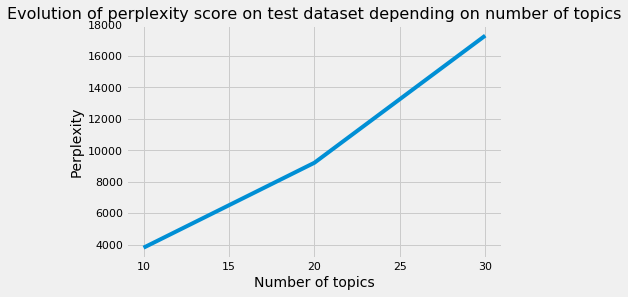

In [15]:
# résultat inattendu, la perplexité augmente quand le nombre de topics augmente
plt.figure(figsize=(6, 4))
plt.style.use('fivethirtyeight')
plt.title("Evolution of perplexity score on test dataset depending on number of topics", fontsize=16)
plt.xlabel("Number of topics", fontsize=14)
plt.ylabel("Perplexity", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.plot(n_topics_list, perplexity_list)
plt.show()

La perplexité augmente avec le nombre de topics, alors qu'elle devrait baisser. 

Sur sklearn, le calcul de la perplexité souffre d'un bug : https://github.com/scikit-learn/scikit-learn/issues/6777 

Je vais donc choisir le nombre de topics qui offre le meilleur compromis entre l’homogénéité de la répartition des topics dans les documents, la variété des topics et leur cohérence. A mon sens, après interprétation des résultats donnés par la fonction **topics_analysis**, ce compromis s’obtient avec un **nombre de topics égal à 20**.

In [17]:
def topics_analysis(lda_model, n_topics, data_vectorized, data_ori):
    
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)
    
    # column names
    topicnames = ["Topic" + str(i) for i in range(n_topics)]
    
    # index names
    docnames = ["Doc" + str(i) for i in range(len(data_ori))]
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
    
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    
    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)
    
    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)
    
    # Apply Style
    df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    #print('n_topics = {} : dominant topic in a sample of documents'.format(n_topics))
    #display(df_document_topics)
    
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="N Documents")
    df_topic_distribution.columns = ['Topic Num', 'N Documents']

    # topics distribution across documents
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.bar(df_topic_distribution['Topic Num'], df_topic_distribution['N Documents'])
    plt.xticks(df_topic_distribution['Topic Num'], rotation='vertical', fontsize=14)
    plt.ylabel("Occurrences", fontsize=14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(11) 
    plt.title('n_topics = {} : topics distribution across documents on test dataset'.format(n_topics), fontsize=16)    
    plt.show()
    
    inv_specialtags = {v: k for k, v in dict(specialtags).items()}
    words_label = []
    for word in tfidf.get_feature_names():
        if word in inv_specialtags.keys():
            words_label.append(inv_specialtags[word])
        else:
            words_label.append(word)

    # Show top n keywords for each topic
    top_words = 8
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:top_words]
        topic_keywords.append(np.array(words_label).take(top_keyword_locs))

    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    print('n_topics = {} : Top {} words for each topic on test dataset'.format(n_topics, top_words))
    display(df_topic_keywords)
    
    # words cloud    
    from wordcloud import WordCloud
    for id_topic in range(n_topics):
        topic_weights = lda_model.components_[id_topic]
        topic_words_weights = [words_label[i] for i in topic_weights.argsort()[:-50 - 1 :-1]]                
        wc = WordCloud(background_color='white').generate(" ".join(topic_words_weights))
        plt.style.use('seaborn')        
        plt.figure(figsize=(12,8))
        plt.imshow(wc, interpolation="bilinear")
        plt.title('n_topics = {} and id_topic = {} : 50 words cloud on test dataset'.format(n_topics, id_topic), fontsize=16)            
        plt.axis('off'); 
                    
    return    

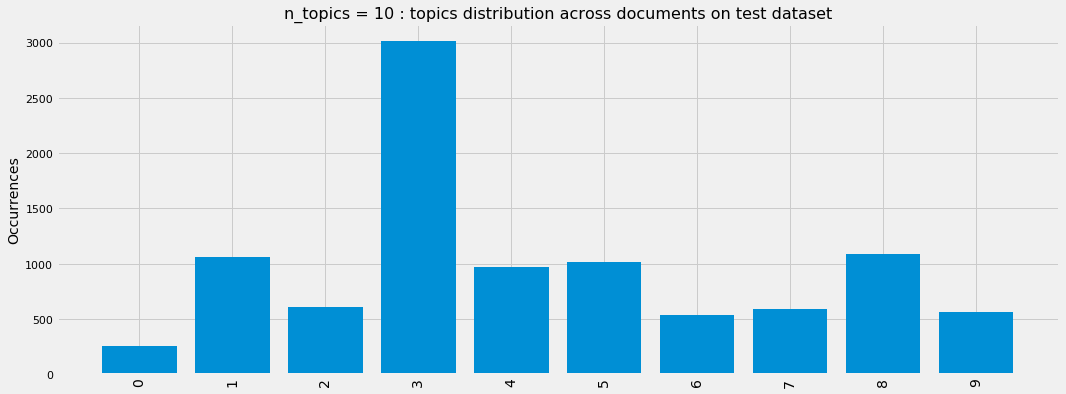

NameError: name 'tfidf' is not defined

In [18]:
for idx, n_topics in enumerate(n_topics_list):
    topics_analysis(lda_model_list[idx], n_topics, X_tfidf_test, X_test)

In [20]:
# Je choisis le LDA correspondant à n_topics = 20
for idx, n_topics in enumerate(n_topics_list):
    if n_topics==20:
        best_lda = lda_model_list[idx]
        print(best_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


## Fonction de recommandation de tags avec approche non supervisée

In [156]:
def pred_nwords_unsupervised(text, tfidf, lda, n_words, specialtags):
    ''' Recommend n_words tags by detecting latent topics in a corpus
    Parameters:    
    text: cleaned text on which recommendations are based
    tfidf: tfidf transformer
    lda: lda model
    n_words: number of words retrieved
    '''
    
    
    document_tfidf = tfidf.transform(text)
    proba_topic_sachant_document = lda.transform(document_tfidf)
    inv_specialtags = {v: k for k, v in dict(specialtags).items()}
    words_label = []
    for word in tfidf.get_feature_names():
        if word in inv_specialtags.keys():
            words_label.append(inv_specialtags[word])
        else:
            words_label.append(word)
    proba_word_sachant_topic = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis] # normalization    
    #print(proba_topic_sachant_document.shape)    
    #print(proba_word_sachant_topic.shape)    
    
    # proba_topic_sachant_document est de dimension d x t
    # proba_word_sachant_topic est de dimension t x w
    # je peux donc opérer un produit matriciel entre les 2 matrices pour calculer pour chaque document : proba(wordn)
    # j'obtiendrai une matrice proba_word_sachant_document de dimension d x w
    # il ne me restera plus qu'à choisir les "n_words" mots les plus probables
    proba_word_sachant_document = proba_topic_sachant_document.dot(proba_word_sachant_topic)  
    
    # je transforme la matrice en dataframe : 
    # data = les proba des mots pour chaque document
    # index = l'index des données en entrée
    # columns = les labels des mots sélectionnés en sortie du LDA
    df_wd = pd.DataFrame(data=proba_word_sachant_document,
                         index=text.index,
                         columns=words_label) 
    
    values = df_wd.columns.values[np.argsort(-df_wd.values, axis=1)[:, :n_words]]
    values = [", ".join(item) for item in values.astype(str)]
    pred_unsupervised = pd.DataFrame(values,
                                     index=df_wd.index,
                                     columns = ['Unsupervised'])
    
    return pred_unsupervised

In [157]:
def apply_specialtags_transco(text, specialtags):
    ''' Transcode tags with punctuation 
    Parameters:
    text: text to transcode
    '''    
    

    for r in specialtags:
        text = text.replace(*r)
        
    return text

from sklearn.utils import resample
few_posts = resample(X_test, n_samples=5, random_state=42)
inv_specialtags = [(v, k) for k, v in dict(specialtags).items()]
pd.concat([pred_nwords_unsupervised(few_posts, tfidf_unsupervised, best_lda, 5, specialtags), 
           few_posts.apply(lambda s: apply_specialtags_transco(s, inv_specialtags)).rename('Cleaned Body')], axis=1)

,Unsupervised,Cleaned Body
44492,"c++, c, c#, array, function",c c++ loop statement
7894,"javascript, html, event, button, form",parentusercontrol host load parentusercontrol access property parentusercontrol childusercontrol time property parent control child control
36398,"java, exception, studio, collection, language",class asset class class definition asset getdefinition class definition asset getdefinitionbyname
17197,"java, collection, class, c#, iphone",java effect point operation java
64422,"eclipse, wpf, service, property, server",application predispatch uri authentication store session zend request object thought authentication zend


In [137]:
# SAUVEGARDE
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(best_lda, f)

In [16]:
#import pyLDAvis.sklearn 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(best_lda, X_tfidf_test_topntags, tfidf_topntags, mds='tsne')
#panel

# Recommandation de tags : approche supervisée

- Binarisation des tags pour l'analyse supervisée
- Séparation  des jeux de données en entraînement et validation
- Vérification de l'équilibre des labels après split
- Transformation de la variable Body avec TF-IDF

In [31]:
# Binarizing the tags for the supervised models
mlb = MultiLabelBinarizer()
Y_target = mlb.fit_transform(posts_topntags_3labels)
    
# 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(posts_body_clean, 
                                                    Y_target, 
                                                    test_size=0.2, train_size=0.8, random_state=42)

## Equilibre des labels après split

In [32]:
import collections
# Fréquence du nombre de tags par document
Y_train_count = collections.Counter(np.sum(Y_train, axis=1))
Y_train_freq = [x[1]/sum(Y_train_count.values()) for x in Y_train_count.most_common()]
print(Y_train_count)
print(Y_train_freq)
Y_test_count = collections.Counter(np.sum(Y_test, axis=1))
Y_test_freq = [-x[1]/sum(Y_test_count.values()) for x in Y_test_count.most_common()]
diff = [x + y for x, y in zip(Y_train_freq, Y_test_freq)]
print(Y_test_count)
print(Y_test_freq)
labels = [x[0] for x in Y_train_count.most_common()]
print(diff)

Counter({1: 18996, 2: 14191, 3: 5634})
[0.48932278921202443, 0.3655495736843461, 0.14512763710362947]
Counter({1: 4724, 2: 3527, 3: 1455})
[-0.48670925200906656, -0.3633834741397074, -0.14990727385122604]
[0.002613537202957872, 0.0021660995446387, -0.004779636747596572]


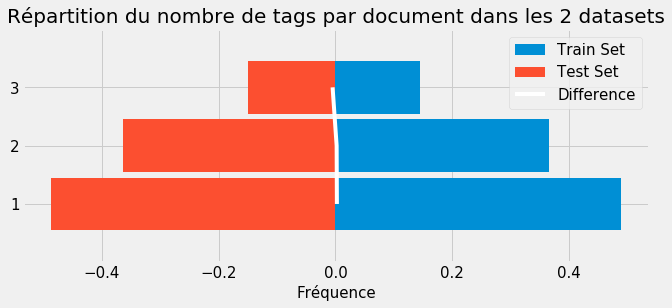

In [33]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,4))
train_barh = ax.barh(np.arange(len(Y_train_freq)), Y_train_freq, 0.9, label="Train Set", linewidth=0, align='center')
test_barh = ax.barh(np.arange(len(Y_test_freq)), Y_test_freq, 0.9, label="Test Set", linewidth=0, align='center')
diff_line, = ax.plot(diff, np.arange(len(Y_test_freq)),'y',linewidth=4, c='white')
ax.set_title("Répartition du nombre de tags par document dans les 2 datasets", fontsize=20)
plt.yticks(np.arange(len(labels)), labels, fontsize=15)
plt.ylim(-1,3)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.set_xlabel("Fréquence", fontsize=15)
ax.legend((train_barh[0],test_barh[0], diff_line),('Train Set','Test Set','Difference'), fontsize=15)
plt.show()

In [83]:
from collections import Counter
# Fréquence du nombre de tags par document
Y_train_count = Counter(x for y in mlb.inverse_transform(Y_train) for x in y)
Y_test_count = Counter(x for y in mlb.inverse_transform(Y_test) for x in y)
#a = [x[0] for x in Y_train_count.most_common()[:-101:-1]]
#b = [x[0] for x in Y_test_count.most_common()[:-101:-1]]
#print(len(list(set(a) | set(b)))) 
# j'obtiens 100 éléments, ce qui signifie que les 2 listes ont tous les éléments en commun
#print(sorted(Y_train_count.most_common()[:-101:-1]))
#print(sorted(Y_test_count.most_common()[:-101:-1]))
# sorted classe les counter par clé = ordre alphabétique et non occurrences des clés
Y_train_freq = [x[1]/sum(x[1] for x in sorted(Y_train_count.most_common()[:-101:-1])) for x in sorted(Y_train_count.most_common()[:-101:-1])]
Y_test_freq = [-x[1]/sum(x[1] for x in sorted(Y_test_count.most_common()[:-101:-1])) for x in sorted(Y_test_count.most_common()[:-101:-1])]
#print(Y_train_freq)
#print(Y_test_freq)


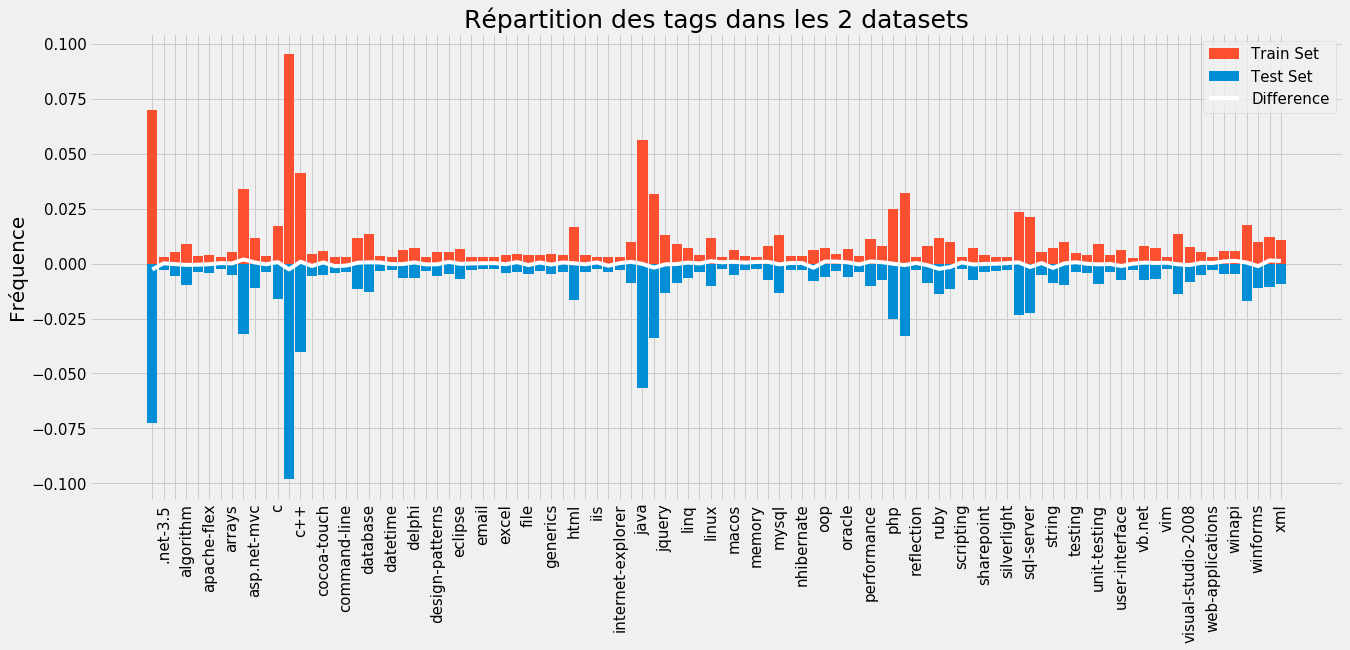

In [84]:
diff = [x + y for x, y in zip(Y_train_freq, Y_test_freq)]
labels = [x[0] for x in sorted(Y_train_count.most_common()[:-101:-1])]
#print(labels)
#print(diff)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,8))
test_bar = ax.bar(np.arange(len(Y_test_freq)), Y_test_freq, 0.9, label="Test Set", linewidth=0, align='center')
train_bar = ax.bar(np.arange(len(Y_train_freq)), Y_train_freq, 0.9, label="Train Set", linewidth=0, align='center')
diff_line, = ax.plot(np.arange(len(Y_test_freq)), diff, 'y', linewidth=4, c='white')
ax.set_title("Répartition des tags dans les 2 datasets", fontsize=25)
plt.xticks(np.arange(len(labels)), labels, fontsize=15, rotation=90)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.set_ylabel("Fréquence", fontsize=20)
ax.legend((train_bar[0],test_bar[0], diff_line),('Train Set','Test Set','Difference'), fontsize=15)
plt.show()

In [17]:
def n_tags_by_labels(data, data_label):
    import matplotlib.pyplot as plt
    # Nombre de tags par document
    Y_n_tags = np.sum(data,axis=1)
    # Fréquence du nombre de tags par document
    import collections
    multiLabel_counts = collections.Counter(Y_n_tags)
    # clés 
    # print([x[0] for x in multiLabel_counts.most_common()])
    # valeurs 
    # print([x[1] for x in multiLabel_counts.most_common()])
    plt.figure(figsize=(15,5))
    ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
    plt.title("Questions having multiple tags : {}".format(data_label), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    plt.ylabel('Number of questions', fontsize=18)
    plt.xlabel('Number of tags', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
    labels = ["{:0.1%}".format(x) for x in labels]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)      
    plt.style.use('fivethirtyeight')        
    return 

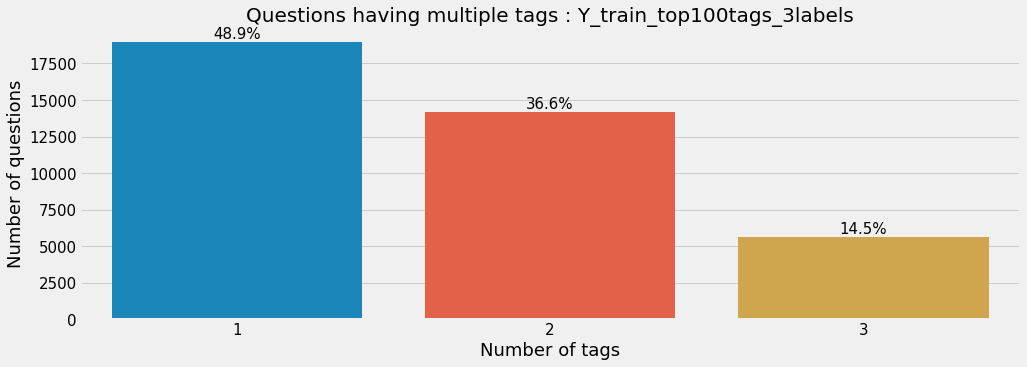

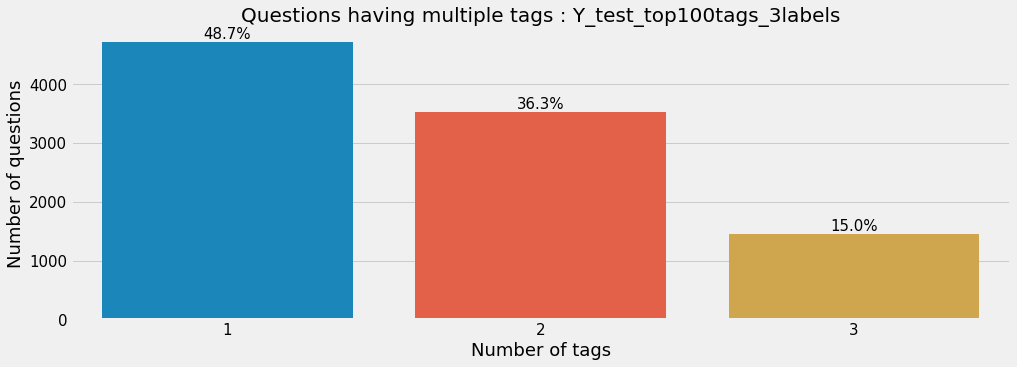

In [18]:
n_tags_by_labels(Y_train, 'Y_train_top100tags_3labels') 
n_tags_by_labels(Y_test, 'Y_test_top100tags_3labels') 

**NB : optimisation du TF-IDF**

Pour l’approche supervisée, je vais tout d'abord chercher à tuner les différents paramètres *min_df*, *max_df* et *max_features* de *TfidfVectorizer* à l’aide d’une recherche par grille visant à maximiser la métrique *jaccard_weighted*. Etant donné la grande dimension de mon vocabulaire et le nombre important de paramètres à tuner, je vais entraîner un classifieur peu gourmand en ressources. 

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')),
    ('clf', OneVsRestClassifier(MultinomialNB()))])

parameters = {
    'tfidf__min_df': [30, 0.001, 0.01],
    'tfidf__max_df': [0.05, 0.1, 0.2],
    'tfidf__max_features': [500, 1000, 2000],    
    'clf__estimator__alpha' : [0.001, 0.01, 0.1] 
}

gs_tfidf = GridSearchCV(pipeline, parameters, scoring='jaccard_weighted', cv=3, n_jobs=-1, verbose=3)
gs_tfidf.fit(X_train, Y_train)

print("Best parameters set:")
print(gs_tfidf.best_params_, gs_tfidf.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.4min finished


Best parameters set:
{'clf__estimator__alpha': 0.01, 'tfidf__max_df': 0.1, 'tfidf__max_features': 1000, 'tfidf__min_df': 30} 0.1565948877424481


In [52]:
print(len(tfidf_supervised.get_feature_names()))
print(tfidf_supervised.get_feature_names())

1636
['ability', 'abstraction', 'access', 'accomplish', 'account', 'accuracy', 'act', 'action', 'actionscript', 'activity', 'ad', 'adapter', 'add', 'addition', 'address', 'adjust', 'admin', 'administration', 'administrator', 'advance', 'advantage', 'advice', 'affect', 'age', 'agent', 'air', 'ajax', 'alert', 'algorithm', 'align', 'alignment', 'allocation', 'alpha', 'alter', 'alternative', 'amount', 'analysis', 'anchor', 'angle', 'animation', 'annotation', 'ansi', 'ant', 'apache', 'api', 'apology', 'app', 'appearance', 'append', 'apple', 'application', 'apply', 'architect', 'architecture', 'area', 'arg', 'array', 'arraylist', 'arrays', 'arrow', 'art', 'article', 'asp', 'aspect', 'aspx', 'assembly', 'assert', 'assertion', 'asset', 'assign', 'assignment', 'assistance', 'association', 'assume', 'assumption', 'attach', 'attachment', 'attack', 'attempt', 'attention', 'attribute', 'audio', 'audit', 'authentication', 'author', 'authorization', 'auto', 'automation', 'avail', 'availability', 'avo

In [139]:
tfidf_supervised = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', min_df=30, max_df=0.1, max_features=1000)
X_tfidf_train = tfidf_supervised.fit_transform(X_train)
X_tfidf_test = tfidf_supervised.transform(X_test)

# SAUVEGARDE
with open('tfidf_supervised.pkl', 'wb') as f:
    pickle.dump(tfidf_supervised, f)

## DummyClassifier

In [87]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier

dummy_clf = OneVsRestClassifier(DummyClassifier(strategy="stratified"))
dummy_clf.fit(X_tfidf_train, Y_train)

Y_train_pred = dummy_clf.predict(X_tfidf_train)
Y_test_pred = dummy_clf.predict(X_tfidf_test)
print('Train : ', jaccard_score(Y_train, Y_train_pred, average='weighted'))
print('Test : ', jaccard_score(Y_test, Y_test_pred, average='weighted'))

Train :  0.02423783574249551
Test :  0.02549557854291796


## MultinomialNB

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(MultinomialNB())

parameters = {
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],
    'estimator__fit_prior' : [True, False]
}

gs_mnb = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1, verbose=3)
gs_mnb.fit(X_tfidf_train, Y_train)

print (gs_mnb.best_params_, gs_mnb.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.5s finished


{'estimator__alpha': 0.001, 'estimator__fit_prior': False} 0.19401582071210505


In [93]:
Y_train_pred = gs_mnb.best_estimator_.predict(X_tfidf_train)
Y_test_pred = gs_mnb.best_estimator_.predict(X_tfidf_test)
print('Train : ', jaccard_score(Y_train, Y_train_pred, average='weighted'))
print('Test : ', jaccard_score(Y_test, Y_test_pred, average='weighted'))

Train :  0.2112384216648561
Test :  0.19527602922193066


## LogisticRegression

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42))

parameters = {
    'estimator__penalty': ['l1', 'l2'], 
    'estimator__C': [0.1, 1, 10, 100, 1000]
}

gs_lr = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1, verbose=3)
gs_lr.fit(X_tfidf_train, Y_train)

print (gs_lr.best_params_, gs_lr.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.4min finished


{'estimator__C': 10, 'estimator__penalty': 'l1'} 0.41944559309404994


In [95]:
Y_train_pred = gs_lr.best_estimator_.predict(X_tfidf_train)
Y_test_pred = gs_lr.best_estimator_.predict(X_tfidf_test)
print('Train : ', jaccard_score(Y_train, Y_train_pred, average='weighted'))
print('Test : ', jaccard_score(Y_test, Y_test_pred, average='weighted'))

Train :  0.5320246261554876
Test :  0.42449203766381044


In [96]:
# SAUVEGARDE
with open('lr_top100tags_3labels.pkl', 'wb') as f:
    pickle.dump(gs_lr.best_estimator_, f)

In [100]:
test_jaccard_list = []
train_jaccard_list = []

for s in np.linspace(0, 1, 10, dtype='float'):

    Y_train_pred = pd.DataFrame(gs_lr.best_estimator_.predict_proba(X_tfidf_train)).applymap(lambda x:1 if x>s else 0).to_numpy()
    train_jaccard_list.append(jaccard_score(Y_train, Y_train_pred, average='weighted'))    
    Y_test_pred = pd.DataFrame(gs_lr.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>s else 0).to_numpy()
    test_jaccard_list.append(jaccard_score(Y_test, Y_test_pred, average='weighted'))    

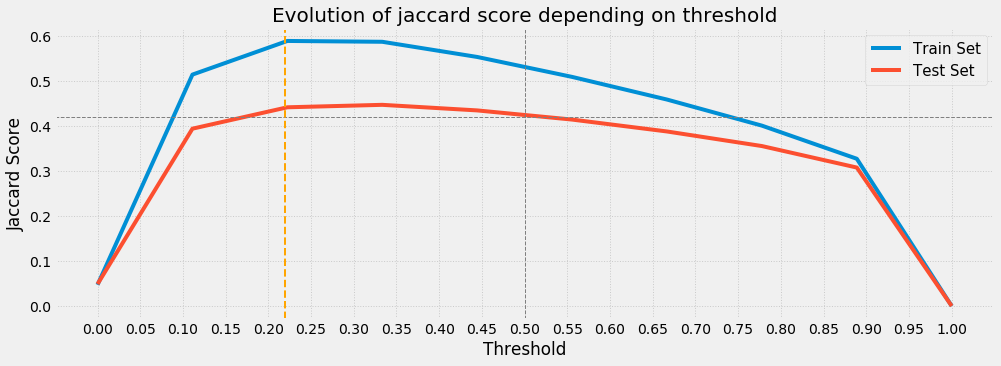

In [130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
plt.style.use('fivethirtyeight')
plt.title("Evolution of jaccard score depending on threshold", fontsize=20)
plt.xlabel("Threshold")
plt.ylabel("Jaccard Score")
ax_train = ax.plot(np.linspace(0, 1, 10, dtype='float'), train_jaccard_list)
ax_test = ax.plot(np.linspace(0, 1, 10, dtype='float'), test_jaccard_list)
ax.axhline(y=0.42, color='gray', linestyle='--', lw=1)
ax.axvline(x=0.5, color='gray', linestyle='--', lw=1)
ax.axvline(x=0.22, color='orange', linestyle='--', lw=2)
plt.xticks(np.arange(0, 1.05, 0.05))
ax.legend((ax_train[0], ax_test[0]),('Train Set','Test Set'), fontsize=15)
ax.grid(True, linestyle=":")
plt.show()

In [134]:
Y_pred1 = pd.DataFrame(gs_lr.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>0.5 else 0).to_numpy()
Y_pred2 = pd.DataFrame(gs_lr.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>0.22 else 0).to_numpy()
Y_true = pd.Series(mlb.inverse_transform(Y_test))
Y_pred1 = pd.Series(mlb.inverse_transform(Y_pred1))
Y_pred2 = pd.Series(mlb.inverse_transform(Y_pred2))
display(pd.concat([Y_true.rename('Y_true'), Y_pred1.rename('Y_pred_0.5'), Y_pred2.rename('Y_pred_0.22')], axis=1)[:10])

,Y_true,Y_pred_0.5,Y_pred_0.22
0,"(ruby, ruby-on-rails)","(performance, ruby, ruby-on-rails)","(performance, ruby, ruby-on-rails)"
1,"(c#,)",(),"(c#,)"
2,"(version-control,)","(algorithm,)","(algorithm,)"
3,"(.net, c++)","(c++,)","(c++,)"
4,"(javascript,)","(javascript,)","(internet-explorer, javascript)"
5,"(command-line, linux)",(),"(shell,)"
6,"(vb.net,)","(vb.net,)","(.net, vb.net)"
7,"(.net, user-interface, vb.net)","(.net,)","(.net, multithreading)"
8,"(css, html, internet-explorer)",(),"(java,)"
9,"(c#, xml)","(c#, xml)","(c#, xml)"


On peut constater l’impact de la modification du seuil sur un échantillon tiré aléatoirement, le modèle est plus enclin à proposer un tag pour un seuil à 0.22 contrairement au seuil à 0.5, sans pour autant que le ou les tags proposés ne soient pas pertinents. 

# Fonction de recommandation de tags

Recommande des mots issus des analyses supervisées et non supervisées

In [144]:
from utils import clean_whitespace_and_code, apply_specialtags_transco, clean_punctuation, stopWordsRemove, lemmatization, pred_nwords_unsupervised

In [152]:
def recommend_tags(text_ori, n_words, seuil=0.5, clean=False):
    
    ''' Recommendation system for StackOverflow posts based on a unsupervised model which returns 
    up to 5 words and and supervised model which returns up to 3 words.
    Parameters:
    text_ori: the stackoverflow post of user
    n_words: number of tags to recommend
    seuil: threshold for decision
    clean: True if data preparation is needed
    '''
    
    # CHARGEMENT
    with open('tfidf_unsupervised.pkl', 'rb') as f:
        tfidf_unsupervised = pickle.load(f)    
    with open('tfidf_supervised.pkl', 'rb') as f:
        tfidf_supervised = pickle.load(f)    
    with open('lda_model.pkl', 'rb') as f:
        lda_model = pickle.load(f)    
    with open('lr_top100tags_3labels.pkl', 'rb') as f:
        clf_model = pickle.load(f) 
    with open('mlb.pkl', 'rb') as f:
        mlb = pickle.load(f) 
    auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
    with open('manual_stopwords.pkl', 'rb') as f:
        manual_stopwords = pickle.load(f) 
    with open('ignore_words.pkl', 'rb') as f:
        ignore_words = pickle.load(f) 
    with open('specialtags.pkl', 'rb') as f:
        specialtags = pickle.load(f)         
    
    if type(text_ori) in (str, pd.Series):
        if type(text_ori) is str:
            text_ori = pd.Series(text_ori) 
        text = text_ori
        text_ori = text_ori.rename("Texte d'origine")
        text = text.rename("Texte modifié")
    else:
        return 'Type should be str or pd.Series'

    if clean==True:
        text = text.apply(lambda s: clean_whitespace_and_code(s))
        text = text.apply(lambda s: BeautifulSoup(s).get_text())
        text = text.apply(lambda s: apply_specialtags_transco(s, specialtags))
        text = text.apply(lambda s: clean_punctuation(s))
        text = text.apply(lambda s: stopWordsRemove(s, auto_stopwords))
        text = text.apply(lambda s: lemmatization(s, ['NOUN'], ignore_words))   
        text = text.apply(lambda s: stopWordsRemove(s, manual_stopwords))

    pred_unsupervised = pred_nwords_unsupervised(text, tfidf_unsupervised, lda_model, n_words, specialtags)
    pred_supervised = pd.DataFrame(clf_model.predict_proba(tfidf_supervised.transform(text))).applymap(lambda x:1 if x>seuil else 0).to_numpy()
    pred_supervised = pd.Series(mlb.inverse_transform(pred_supervised), name='Supervised', index=text.index)
    pred_supervised = pred_supervised.apply(lambda row: ', '.join(row))
    result = pd.concat([pred_supervised, pred_unsupervised, text_ori, text], axis=1)
    
    return result

In [155]:
posts_body_clean = pd.read_pickle("./posts_body_clean.pkl")    

test = "this sql request grouping values by keys on the relational database is not working."
display(recommend_tags(test, 5, seuil=0.22, clean=True))

test = "I want to develop a web application generating html, javascript and css, what is the good language to do that."
display(recommend_tags(test, 5, seuil=0.22, clean=True))

test = "I want to code a Python function to sum item from a dictionary."
display(recommend_tags(test, 5, seuil=0.22, clean=True))

test = posts_body_clean.loc[2:5]
display(recommend_tags(test, 5, seuil=0.22, clean=False))
#test = X_test[:2]

,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"database, sql, sql-server","sql, table, database, server, column",this sql request grouping values by keys on the relational database is not working.,sql request key database


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"asp.net, css, html, javascript","javascript, html, event, button, form","I want to develop a web application generating html, javascript and css, what is the good language to do that.",web application html javascript css


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,python,"python, string, object, memory, variable",I want to code a Python function to sum item from a dictionary.,python item


,Supervised,Unsupervised,Texte d'origine,Texte modifié
2,c#,"python, string, function, list, class",person birthday calculate age age xyzspecialtags26zyx,person birthday calculate age age xyzspecialtags26zyx
3,"c#, datetime","python, string, list, function, date",display time hour day month calculate time xyzspecialtags26zyx,display time hour day month calculate time xyzspecialtags26zyx
4,"asp.net, web-services","javascript, java, html, service, server",web server determine timezone web http header string determine timezone,web server determine timezone web http header string determine timezone
5,".net, math","sql, table, database, server, column",xyzspecialtags25zyx math floor math,xyzspecialtags25zyx math floor math


In [28]:
test = posts_body_clean.loc[2:5]
test

2    person birthday calculate age                       
3    display time hour day month                         
4    web server determine timezone web http header string
5    xyzspecialtags1zyx                                  
Name: Body, dtype: object